# **Japanese-English Neural Machine Translation**

## Table of Contents

- [Introduction](#Introduction)
- [Preprocessing](#Preprocessing)
- [Model fine-tuning](#Model-Fine-Tuning)
- [Model Evaluation](#Model-Evaluation)
- [Model Evaluation Methods](#Model-Evaluation-Methods)
- [Subtitle Generator](#Model-Evaluation)
- [References](#References)

# Introduction

In computer science human languages are referred to as “natural” languages to distinguish them from languages designed for machines like Assembly, or Python. Every machine language was designed - it started out with a human engineer writing down a set of formal rules for the usage of that language. In contrast natural language was shaped by an evolution process, much like biological organisms—that’s what makes it “natural.” Its “rules,” like the grammar of English, were formalized after the fact and are often ignored or broken by its users. As a result, while machine-readable language is highly structured and rigorous, using precise syntactic rules to weave together exactly defined concepts from a fixed vocabulary, natural language is messy—ambiguous, chaotic, sprawling, and constantly in flux.

Machine learning approaches to natural language processing started out in the late 1980s, after a failed collaboration approach between linguists and engineers to handcraft the rules of language and feed them to machines. Probably questions that preceded machine learning were: “Could I use a corpus of data to automate the process of finding these rules? Could I search for the rules within some kind of rule space, instead of having to come up with them myself?”

Modern NLP is about: using machine learning and large datasets to give computers the ability not to understand language, which is a more lofty goal, but to ingest a piece of language as input and return something useful, like predicting the following:
*   “What’s the topic of this text?” (text classification)
* “Does this text contain abuse?” (content filtering)
* “Does this text sound positive or negative?” (sentiment analysis)
* “What should be the next word in this incomplete sentence?” (language modeling)
* “How would you say this in German?” (translation)
* “How would you summarize this article in one paragraph?” (summarization) etc.

The first machine learning strategies leveraged decision trees, and statistical approaches like logistic regression. Around 2014–2015, things started changing at last. Multiple researchers began to investigate the language-understanding capabilities of recurrent neural networks, in particular LSTM—a sequence-processing algorithm from the late 1990s that had stayed under the radar until then.

Finally, around 2017–2018, a new architecture rose to replace RNNs: the Transformer. Transformers unlocked considerable progress across the field in a short period of time, and today most NLP systems are based on them.

# Objective
In this project I aim to build a subtitles translator system from Japanese to English, with option to add Romanization into the generated subtitles. As a japanese learner having the option to switch between english translation and japanese romanization while watching fun movies would greatly benefit my japanese language skills.

I utilize the pre-trained [Opus Ja-En](https://huggingface.co/Helsinki-NLP/opus-mt-ja-en) Tranformers based translation model by fine-tuning it on the JESC dataset.

* JESC is a large Japanese-English parallel corpus covering the underrepresented domain of conversational dialogue. It consists of more than 3.2 million examples, making it the largest freely available dataset of its kind. The corpus was assembled by crawling and aligning subtitles found on the web. The assembly process incorporates a number of novel preprocessing elements to ensure high monolingual fluency and accurate bilingual alignments. Its contents were summarized and evaluated using human experts and baseline machine translation (MT) systems. You can find out more about the process [here](https://arxiv.org/pdf/1710.10639v4.pdf).
* Additionally the Opus model was initially tested with the [Tatoeba dataset](https://paperswithcode.com/dataset/tatoeba) which is a free collection of example sentences with translations geared towards foreign language learners. The model had achieved the remarkable BLEU score(common evaluation metric for MT) of 41.7 on that dataset. We'll talk more about the metrics for evaluating machine translation in a later stage.

# Preprocessing

The first part of MT task is preparing the data. This includes cleaning the text data from anything not relevant to the task like some punctuations, upper-case, HTML/URLs, stop words such as "the", "is", "and", handling special characters and numbers, lemmatization, stemming(reduce words to their base or root form.) etc. Often some of these don't hold significant meaning for the task at hand for the model, so keeping it would only add noise. However we have to carefully consider the context, because e.g. leaving upper-case words would be very important for tasks like named entity recognition (NER) or information extraction.

It is essential to perform tokenization which is the process of breaking down a text into smaller units called tokens. These tokens can be words, characters, or subwords, depending on the granularity of the tokenization process. Then we convert text data into numerical representations, or so called vectorization. This allows machines to understand and process human language.

In order to choose a tokenization method we need to have in mind the task at hand. E.g. in translation tasks it would be more beneficial to use word-level tokenization, but for a handwriting recognition task character-level tokenization would be a better choice. If we will fine-tune, or do transfer learning, we have to ensure that the tokenization method is compatible with the downstream model or application. Some models may require specific tokenization schemes or input formats.

Different languages and text types may require different tokenization approaches. For example, languages with complex morphology or agglutinative languages may benefit from subword tokenization methods, while languages with simpler structures may be adequately represented with word-level tokenization.

## Japanese tokenization specifics
Japanese written language doesn't have space between words, and utilizes three different types of 'alphabets' (kanji, hiragana, and katakana) that are interrelated, and in one japanese sentence you can see all three of them blended. Additionally many japanese words are comprised of both kandji and hiragana. You can imagine linguistically motivated tokenization is a challenge!

The model I'll fine tune performs __Normalization and SentencePiece tokenization__, this a sub-wording approach, which would be easier to implement for languages as Japanese where semantic division is a complex task. There are quite a few other methods that use japanese vocabularies to assist in linguistical separation of words which would allow a word/morpheme-level tokenizatin for japanese as well. There are different approaches to forming these vocabularies so depending on that the results of each tokenization method is different. [This article](https://blog.octanove.org/japanese-pretrained-models/) that compares BERT-based models for Japanese language points out that morphology-based tokenization, or emphasis on the linguistical meaning of the words achieves better performance than SentencePiece.

## Comparing japanese tokenization methods

I tested tokenizing Japanese with [fugashi](https://aclanthology.org/2020.nlposs-1.7.pdf) and unidic-lite dictionary, this is a Japanese tokenizer and morphological analysis tool. Then I compared the results with the SentencePiece tokenizer of Opus model. You can see the comparison later in the notebook.


Importing and installing required libraries.

In [ ]:
! pip install datasets transformers[torch] sacrebleu torch evaluate
#! pip install accelerate -U
! pip install fugashi[unidic-lite]

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import files, drive
import random
import os

import torch

from datasets import Dataset

In [ ]:
# It's important to ensure you're using GPU/TPU during training, otherwise it will be way slower. You can use this code when you import the model.
model = model.to('cuda')

In [ ]:
#https://colab.research.google.com/notebooks/pro.ipynb#scrollTo=23TOba33L4qf
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Feb  8 20:29:14 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0              26W /  70W |    399MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
print(model.device)

cuda:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd //content/drive/MyDrive/split

/content/drive/MyDrive/split


In [ ]:
# Download a file using !wget
!wget "https://nlp.stanford.edu/projects/jesc/data/split.tar.gz" -O "split.tar.gz"

# Unzip the tar.gz file using !tar
!tar -xzf split.tar.gz

--2024-01-30 16:33:54--  https://nlp.stanford.edu/projects/jesc/data/split.tar.gz
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102198329 (97M) [application/x-gzip]
Saving to: ‘split.tar.gz’

split.tar.gz        100%[===================>]  97.46M  30.9MB/s    in 4.5s    

2024-01-30 16:33:59 (21.8 MB/s) - ‘split.tar.gz’ saved [102198329/102198329]



In [ ]:
# Set the random seed for reproducibility.
def set_seed(seed: int = 42) -> None:
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)
  tf.experimental.numpy.random.seed(seed)
  #tf.set_random_seed(seed)
  # When running on the CuDNN backend, two further options must be set
  os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
  os.environ['TF_DETERMINISTIC_OPS'] = '1'
  # Set a fixed value for the hash seed
  os.environ["PYTHONHASHSEED"] = str(seed)
  print(f"Random seed set as {seed}")

In [ ]:
SEED = 32447555
set_seed(SEED)

## Data cleaning and exploration
We clean the data by removing empty rows, duplicates, nan's, exceed max length, HTML tags, apply normalization and lower case(in this case it's not needed as the data is already lower-cased), shuffle the dataset, and save the files.

I also review the length of the sentences to choose a suitable size for the model. We will use it for subtitle generation so they don't have to be too long.

I'm also comparing the length of japanese and english sentences to get familiar with the languages and see the differences.

In [ ]:
def preprocess(dataset, source_lang, target_lang, lower=False):

    df = pd.read_csv(dataset, names=['Target', 'Source'], sep="\t", quoting=3, skip_blank_lines=False, on_bad_lines="skip", encoding = 'utf-8')
    print("Dataframe shape (rows, columns):", df.shape)

    # Delete nan
    df = df.dropna()

    print("--- Rows with Empty Cells Deleted\t--> Rows:", df.shape[0])

    # Drop duplicates
    df = df.drop_duplicates()
    #df = df.drop_duplicates(subset=['Target'])

    print("--- Duplicates Deleted\t\t\t--> Rows:", df.shape[0])

    # Drop source-target matching rows
    df["Source-Target"] = df['Source'] == df['Target']
    df = df.set_index(['Source-Target'])

    try: # To avoid (KeyError: '[True] not found in axis') if there are no source-copied cells
        df = df.drop([True]) # Boolean, not string, do not add quotes
    except:
        pass

    df = df.reset_index()
    df = df.drop(['Source-Target'], axis = 1)

    print("--- Source-Target matching rows Deleted\t--> Rows:", df.shape[0])

    # Drop rows above max length (source or target)
    df["Max-Length"] = (((df['Source'].apply(len) > 400) |
    (df['Target'].apply(len) > 400))
    )

    #display(df.loc[df['Max-Length'] == True]) # display only rows above max length
    df = df.set_index(["Max-Length"])

    try: # To avoid (KeyError: '[True] not found in axis') if there are no too-long cells
        df = df.drop([True]) # Boolean, not string, do not add quotes
    except:
        pass

    df = df.reset_index()
    df = df.drop(["Max-Length"], axis = 1)

    print("--- Rows above Max Length Deleted\t--> Rows:", df.shape[0])

    # Remove HTML and normalize
    df = df.replace(r'<.*?>|&lt;.*?&gt;|&?(amp|nbsp|quot);|{}', ' ', regex=True)
    df = df.replace(r'\s+', ' ', regex=True)  # replace double-spaces with one space

    print("--- HTML Removed\t\t\t--> Rows:", df.shape[0])

    # Lower-case the data
    if lower == True:
        df['Source'] = df['Source'].str.lower()
        df['Target'] = df['Target'].str.lower()

        print("--- Rows are now lower-cased\t--> Rows:", df.shape[0])
    else:
        print("--- Rows will remain in true-cased\t--> Rows:", df.shape[0])


    # Replace empty cells with NaN
    df = df.replace(r'^\s*$', np.nan, regex=True)

    # Delete nan (already there, or generated from the previous steps)
    df = df.dropna()

    print("--- Rows with Empty Cells Deleted\t--> Rows:", df.shape[0])


    # Shuffle the data
    df = df.sample(frac=1, random_state=SEED).reset_index(drop=True)
    print("--- Rows Shuffled\t\t\t--> Rows:", df.shape[0])

    # Write the dataframe to two Source and Target files
    source_file = dataset+'-preprocessed.'+source_lang
    target_file = dataset+'-preprocessed.'+target_lang

    # Save source and target to two text files
    df_source = df["Source"]
    df_target = df["Target"]

    df_source.to_csv(source_file, header=False, index=False, quoting=3, sep="\n")
    print("--- Source Saved:", source_file)
    df_target.to_csv(target_file,header=False, index=False, quoting=3, sep="\n")
    print("--- Target Saved:", target_file)

In [ ]:
preprocess('train', 'ja', 'en', lower=False)
#preprocess('dev', 'ja', 'en', lower=False)
#preprocess('test', 'ja', 'en', lower=False)

Dataframe shape (rows, columns): (2797388, 2)
--- Rows with Empty Cells Deleted	--> Rows: 2797388
--- Duplicates Deleted			--> Rows: 2797388
--- Source-Target matching rows Deleted	--> Rows: 2797284
--- Rows above Max Length Deleted	--> Rows: 2797284
--- HTML Removed			--> Rows: 2797284
--- Rows will remain in true-cased	--> Rows: 2797284
--- Rows with Empty Cells Deleted	--> Rows: 2796000
--- Rows Shuffled			--> Rows: 2796000
--- Source Saved: train-preprocessed.ja
--- Target Saved: train-preprocessed.en


We want to double-check if the translations are in line after this preprocessing step.

In [ ]:
#Function to check if source and target files are in line.
def read_lines(file1, file2, num_lines):
    if isinstance(file1, list) and isinstance(file2, list):
        lines_file1 = file1[:num_lines]
        lines_file2 = file2[:num_lines]
    elif isinstance(file1, str) and isinstance(file2, str):
        with open(file1, 'r', encoding='utf-8') as file:
            lines_file1 = [next(file).strip() for _ in range(num_lines)]

        with open(file2, 'r', encoding='utf-8') as file:
            lines_file2 = [next(file).strip() for _ in range(num_lines)]
    else:
        raise ValueError("Input types not supported")

    for line1, line2 in zip(lines_file1, lines_file2):
        print(f"{line1.strip()}\t\t\t{line2.strip()}")

In [ ]:
file1 = 'train-preprocessed.ja'
file2 = 'train-preprocessed.en'

read_lines(file1, file2, 10)

tiランキングで10~20ランクが上昇して			and china will move up 10 to 20 notches
なんでよ みんな同類じゃん			so now, everyone...
俺は好きだよ			and i like it.
何だ?- お帰りですか?			no way.
集中って何が・・・!			concentrate? whatever.
はっきり言うと			let me be clear.
あの体格から見て 得意技は多分つかみと投げ			i am mister pleiades!
一緒に来るんだ 君を守る さあ			come with me. i need you alive. now.
良くなるという程では ないかもしれません			being a banker better than being an artist.
しばらく無縁仏けとして保管する。			and he needs to stay a john doe until i say otherwise.


Reviewing the spelling, even though the creators of this dataset applied to it laplace-smoothed statistical error model P(w|w∗) that scores the probability of a word w∗ being misspelled as w, and fixes it.
There are some spelling errors, but for the sake of the demo we'll skip the fixing. Additionally some errors could serve as perturbations for the model, so it's more adaptable to future subtitle files that naturally contain errors due to fanmade translation.

In [ ]:
spell = SpellChecker()

# find those words that may be misspelled
en_text = ja_en_srt['en'][3].split()

for word in en_text:
    # Get the one `most likely` answer
    print(spell.correction(word))

    # Get a list of `likely` options
    print(spell.candidates(word))

yeah
{'yeah', 'yeahs'}
ism
{'ism', "h'm"}
fine
{'finer', 'fined', 'fine', 'fines'}


_Optional_ If you want to experiment with pre-tokenizing japanese sentences with fugashi, you can use the following code. I will skip that part in this notebook.
```
import fugashi

#Creating the Tagger object is a lot of work for the computer. When processing text in a loop it’s important you re-use the Tagger rather than creating a new Tagger for each input.

tagger = fugashi.Tagger()

def tokenize_ja(dataset):
    with open(dataset, 'r', encoding='utf-8') as file:
      content = file.readlines()

    tokenized_ja = []
    for text in dataset:
        words = [word.surface for word in tagger(text)]
        sentence = ' '.join(words)
        tokenized_ja.append(sentence)
    return tokenized_ja

```




In [ ]:
#Here's how the data looks after pre-tokenizing    #train_ja_tokenized

,ja
0,博物 館 だ
1,様々 な パートナーシップ を もつ
2,《 コラッ お前 と いう ヤツ は . . . 》
3,"aldi の 販売 品目 数 は たった の 1 , 400 です"
4,あ ~ 天ぷら 好き です 。 ヨーコ も 好き か 。
...,...
2795995,セックス は ない けど 私 に 出来 ない 物 を 与え て た
2795996,行っ て き まー す ! あれ キャバクラ じゃん
2795997,ヨンエ を 救出 しよう と し て いる ん です
2795998,今 も ?


In [ ]:
#The amount of words were obtained after tokenizing with fugashi.

train_ja_tokenized['word_count'] = train_ja_tokenized['ja'].apply(lambda x: len(str(x).split()))
row_with_most_words = train_ja_tokenized.loc[train_ja_tokenized['word_count'].idxmax()]
max_word_count = train_ja_tokenized['word_count'].max()

print(f"Row with the most words: '{row_with_most_words}'")
print(f"Word count: {max_word_count}")

Row with the most words: 'ja            袖 が きつい し ミディ 襟 は ショール ラペル に 合っ て ない の に 加え 裾 ...
word_count                                                   83
Name: 2432792, dtype: object'
Word count: 83


Comparing the difference between the AutoTokenizer's divisions that aren't based on japanese vocabulary(_Non-pretokenized_), and mix of Pretokenization with fugashi + AutoTokenizer.


In [ ]:
from tabulate import tabulate

table_data = []
for i, (sentence_tokens, sentence_tokens_pre) in enumerate(zip(sentences[:10], sentences_pre[:10])):
    num_tokens = len(sentence_tokens)
    num_tokens_pre = len(sentence_tokens_pre)
    table_data.append([f"S{i + 1}", num_tokens, num_tokens_pre])

headers = ["Sentence", "Ja Tokens (Non-pretokenized)", "Ja Tokens (Pretokenized)"]
print(tabulate(table_data, headers=headers, tablefmt="grid"))

+------------+--------------------------------+----------------------------+
| Sentence   |   Ja Tokens (Non-pretokenized) |   Ja Tokens (Pretokenized) |
+============+================================+============================+
| S1         |                              5 |                          5 |
+------------+--------------------------------+----------------------------+
| S2         |                             13 |                         13 |
+------------+--------------------------------+----------------------------+
| S3         |                              5 |                          7 |
+------------+--------------------------------+----------------------------+
| S4         |                             13 |                         17 |
+------------+--------------------------------+----------------------------+
| S5         |                             14 |                         16 |
+------------+--------------------------------+----------------------------+

I'll truncate and then train/test split the training set as it's quite large, and I don't plan on training on the whole dataset at this moment.

In [ ]:
#Import the preprocessed(cleaned) datasets

def read_files(path):
    with open(path, "r", encoding="utf-8") as f:
        dataset = f.read().split("\n")[:-1]
    return dataset

ja_file = read_files("train-preprocessed.ja")
en_file = read_files("train-preprocessed.en")

jaen_dict = {'ja': ja_file, 'en': en_file}
jaen_dataset = Dataset.from_dict(jaen_dict)

In [ ]:
jaen_dataset, jaen_dataset[0]

(Dataset({
     features: ['ja', 'en'],
     num_rows: 2796000
 }),
 {'ja': 'tiランキングで10~20ランクが上昇して',
  'en': 'and china will move up 10 to 20 notches'})

Truncating the dataset for training.

In [ ]:
# Function to truncate dataset
def truncate_dataset(dataset, num_samples):
    return dataset.select(range(num_samples))

# Number of samples to keep
num_samples = 120000

jaen_dataset_tr = truncate_dataset(jaen_dataset, num_samples)

AttributeError: 'Dataset' object has no attribute 'columns'

Splitting into three sets: train, validation, test. We will be using train and validation sets for experimenting, and finally use the testing set on the best model.

In [ ]:
# Function for train/test split
def train_test_split(dataset):

    total_size = len(dataset)
    train_size = int(0.70 * total_size)
    val_size = int(0.10 * total_size)

    # Split the lines
    train = dataset[:train_size]
    val = dataset[train_size:train_size + val_size]
    test = dataset[train_size + val_size:]

    train = Dataset.from_dict(train)
    val = Dataset.from_dict(val)
    test = Dataset.from_dict(test)
    return train, val, test

In [ ]:
train, val, test = train_test_split(jaen_dataset_tr)
train, val, test

(Dataset({
     features: ['ja', 'en'],
     num_rows: 84000
 }),
 Dataset({
     features: ['ja', 'en'],
     num_rows: 12000
 }),
 Dataset({
     features: ['ja', 'en'],
     num_rows: 24000
 }))

# Model Fine-tuning

Transformers models have been the benchmark for NMT since 2017. [HuggingFace](https://huggingface.co/) is a hub full of pre-trained models that you can leverage easily for many machine learning tasks.

Before that NMT models were based on RNNs(LSTMs). Transformers outplace RNNs with simultaneous input processing and are easier to train than LSTMs due to fewer parameters. What makes Transformers special is the self-attention mechanisms.

Another disadvantage of RNNs are they cannot remember longer sentences and sequences due to the vanishing/exploding gradient problem. Even Cho et al (2014), who proposed the encoder-decoder network, demonstrated that the performance of the encoder-decoder network degrades rapidly as the length of the input sentence increases. E.g. it has been observed that the encoder creates a bad summary when it tries to understand longer sentences.<br>
__Attention__ was introduced by Bahdanau et al (2015) - not only can all the input words can be taken into account in the context vector, but relative importance should also be given to each one of them. So, whenever the proposed model generates a sentence, it searches for a set of positions in the encoder hidden states where the most relevant information is available.


![image.png](https://blog.finxter.com/wp-content/uploads/2023/07/image-33.png))

I'll fine tune the Opus Ja-En dataset that already has a very good BLEU score of 41.7. Later I will test how does it perform on the JESC dataset.



In [ ]:
# Load model and tokenizer
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer


checkpoint = "Helsinki-NLP/opus-mt-ja-en"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/782k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.50M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:197: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


pytorch_model.bin:   0%|          | 0.00/303M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

In [ ]:
source_lang = 'ja'
target_lang = 'en'

def tokenize_function(examples):
    inputs = examples[source_lang]
    targets = examples[target_lang]
    model_inputs = tokenizer(inputs, text_target=targets, max_length=128, truncation=True)
    return model_inputs

In [ ]:
tokenized_train = train.map(tokenize_function, batched=True)

tokenized_train.to_json("//content/drive/MyDrive/split/pretokenized_train_pt_tr.json")

Map:   0%|          | 0/84000 [00:00<?, ? examples/s]

Creating json from Arrow format:   0%|          | 0/84 [00:00<?, ?ba/s]

24462597

In [ ]:
tokenized_val = val.map(tokenize_function, batched=True)

tokenized_val.to_json("//content/drive/MyDrive/split/pretokenized_val_pt_tr.json")

Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

Creating json from Arrow format:   0%|          | 0/12 [00:00<?, ?ba/s]

3491453

In [ ]:
#Loading the tokenized files if preprocessed in different session
from datasets import load_dataset

json_file_path = "//content/drive/MyDrive/split/pretokenized_val_pt_tr.json"

tokenized_val = load_dataset('json', data_files=json_file_path)

tokenized_val['val'] = tokenized_val.pop('train')

json_file_path2 = "//content/drive/MyDrive/split/pretokenized_train_pt_tr.json"

tokenized_train = load_dataset('json', data_files=json_file_path2)

tokenized_train
tokenized_val

#Changing data type to be compatible with model
tokenized_train = tokenized_train #['train']
tokenized_val = tokenized_val #['val']

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
tokenized_train, tokenized_val

(DatasetDict({
     train: Dataset({
         features: ['ja', 'en', 'input_ids', 'attention_mask', 'labels'],
         num_rows: 84000
     })
 }),
 DatasetDict({
     val: Dataset({
         features: ['ja', 'en', 'input_ids', 'attention_mask', 'labels'],
         num_rows: 12000
     })
 }))

In [ ]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=checkpoint)

In [ ]:
import evaluate

metric = evaluate.load("sacrebleu")

In [ ]:
import numpy as np


def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels


def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": result["score"]}

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    return result

In [ ]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

In [ ]:
model = model.to('cuda')

In [ ]:
print(model.device)

cuda:0


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


Set up mlflow to log the model parameters easily. If you don't have it set up on your computer, you can create a free account in [Databricks](https://community.cloud.databricks.com/) and follow the lines of code below. You can use the autolog, or log the parameters, metrics, artifacts etc. manually, see the [documentation](https://mlflow.org/docs/latest/python_api/mlflow.pytorch.html) of mlflow.pytorch.

In [ ]:
!pip install mlflow
!databricks configure --host https://community.cloud.databricks.com/

In [ ]:
import mlflow
mlflow.set_tracking_uri("databricks")
mlflow.set_experiment("/NMT")

In [ ]:
mlflow.pytorch.autolog()

If you want to save your fine-tuned model in huggingface you need to login to your account, and you will be asked to paste a token from HF. If you won't do that make sure to include this line of code in the cell of trainer.train() to save your model somewhere.


```
filepath = "name_of_the_model"
torch.save(model.state_dict(), filepath)
```

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
# Experiment 4
training_args = Seq2SeqTrainingArguments(
    output_dir="experiment4",
    evaluation_strategy="steps",
    save_steps = 20000,
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    lr_scheduler_type = "cosine",
    predict_with_generate=True,
    fp16=True
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train["train"],
    eval_dataset=tokenized_val["val"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

Step,Training Loss,Validation Loss,Bleu,Gen Len
500,2.117700,2.417419,12.227700,12.789200
1000,2.523400,2.375198,11.407200,13.404900
1500,2.495900,2.356847,11.741900,13.379200
2000,2.469000,2.341254,12.664800,12.667300
2500,2.463500,2.328443,12.096600,13.031500
3000,2.283000,2.327843,12.045800,13.039200
3500,2.209000,2.323467,13.432100,12.088000
4000,2.206600,2.318939,12.852300,12.568600
4500,2.209800,2.313193,12.982700,12.479200
5000,2.207300,2.309207,12.887000,12.583600


TrainOutput(global_step=7875, training_loss=2.239193126860119, metrics={'train_runtime': 17756.7129, 'train_samples_per_second': 14.192, 'train_steps_per_second': 0.443, 'total_flos': 1487553473544192.0, 'train_loss': 2.239193126860119, 'epoch': 3.0})

In [ ]:
#End the run to be able to log the new model's params
mlflow.end_run()

In [ ]:
#Experiment 5
training_args = Seq2SeqTrainingArguments(
    output_dir="opus-jesc-ja-en2",
    evaluation_strategy="steps",
    save_steps = 525,
    learning_rate=5e-4,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    lr_scheduler_type = "cosine",
    predict_with_generate=True,
    fp16=True,
    push_to_hub=True,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train["train"],
    eval_dataset=tokenized_val["val"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

filepath = "/opus-jesc-ja-en2/"
torch.save(model.state_dict(), filepath)

Step,Training Loss,Validation Loss,Bleu,Gen Len
500,3.702300,3.831547,4.687900,11.155000
1000,3.906600,3.843625,3.660000,12.175800
1500,3.838800,3.720305,1.934600,23.086100
2000,3.747200,3.616077,4.014000,12.809100


KeyboardInterrupt: 

# Model Evaluation

One tool to analyse the state of the model is the __Learning Curve__. It illustrates the development of the loss function(or any other relevant metric) during training. We can evaluate on both the train and validation datasets. The train set results give an idea how well the model is "learning." Evaluation on the validation dataset gives an idea of how well the model is “generalizing.”

The shape and dynamics of a learning curve can be used to diagnose the behavior of a machine learning model.

There are three common dynamics that you can observe in learning curves: underfit, overfit, good fit. We always first aim for overfitting the model which implies it learns the data very well, and then we regularize, so it also learns to generalize. In contrast an underfit model is one that cannot learn the training dataset.

An example of a Learning curve that illustrates a good fit is:
* The plot of training loss decreases to a point of stability.
* The plot of validation loss decreases to a point of stability and has a small gap with the training loss.
![image.png](https://machinelearningmastery.com/wp-content/uploads/2018/12/Example-of-Train-and-Validation-Learning-Curves-Showing-A-Good-Fit.png)

[More info](https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/)

In the case of __my first experiment(4)__ the training loss goes down over time, achieving lower error values, howerver the validation loss remains the same, which creates a gap between the two. This indicates high variance. The model is too complex and captures too much noise in the data, which prevents it from generalizing. This issue could be also improved by increasing the size of the dataset.

The __2nd experiment(5)__ which has a way higher learning rate, has decreasing loss on both train and validation sets, this indicates it underfits, however the training was stopped in the beginning due to significantly lower scores, it might've improved over time.




In [ ]:
# Function that plots the Learning Curve
import csv

# Function that reads the .csv with train_loss/val_loss scores from mlflow
def read_csv_to_dict_list(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        csv_reader = csv.DictReader(file)
        return list(csv_reader)

def learningcurve(data, experiment):
    learning_rate_steps = []
    learning_rates = []
    eval_loss_steps = []
    eval_losses = []

    for entry in data:
        if entry['key'] == 'loss':
            learning_rate_steps.append(int(entry['step']))
            learning_rates.append(float(entry['value']))
        elif entry['key'] == 'eval_loss':
            eval_loss_steps.append(int(entry['step']))
            eval_losses.append(float(entry['value']))

    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 6))

    plt.plot(learning_rate_steps, learning_rates, label='Train loss', linestyle='-', color='blue')

    plt.plot(eval_loss_steps, eval_losses, label='Val Loss', linestyle='--', color='red')

    plt.xlabel('Step')
    plt.ylabel('Value')
    plt.title(f'Learning Curve of {experiment}')
    plt.legend()
    plt.grid(True)
    plt.show()

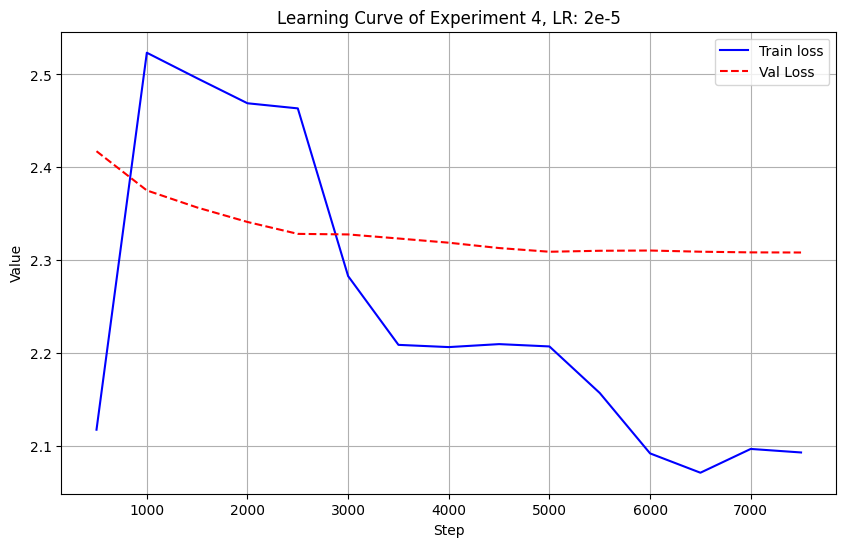

In [ ]:
lr_ex42 = read_csv_to_dict_list("lr_ex4.csv")

experiment = 'Experiment 4, LR: 2e-5'

learningcurve(lr_ex42, experiment)

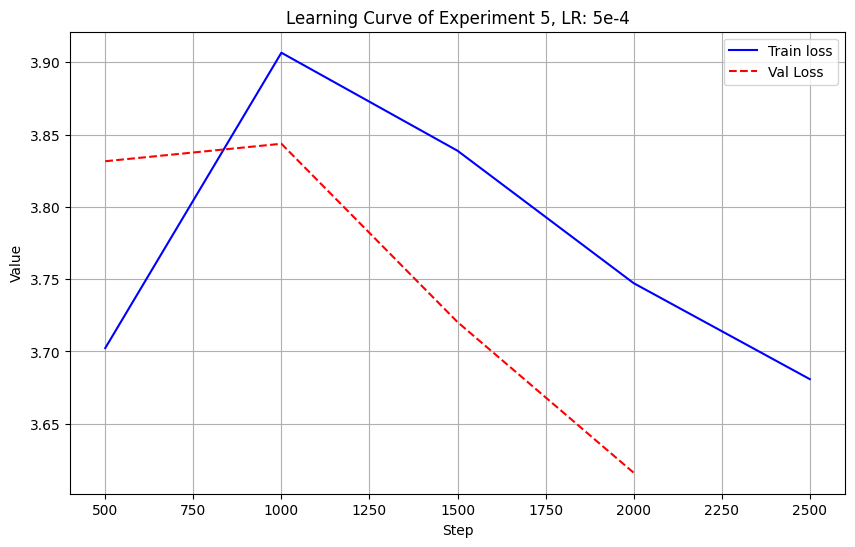

In [ ]:
lr_ex5 = read_csv_to_dict_list("lr_ex5.csv")

experiment = 'Experiment 5, LR: 5e-4'

learningcurve(lr_ex5, experiment)

## Learning rate

The __learning rate__ controls how quickly the model is adapted to the problem. Smaller learning rates require more training epochs given the smaller changes made to the weights each update, whereas larger learning rates result in rapid changes and require fewer training epochs.

A learning rate that is too large may result in learning a sub-optimal set of weights too fast or an unstable training process, whereas a learning rate that is too small can cause the process to get stuck.

The challenge of training deep learning neural networks involves carefully selecting the learning rate. It may be the most important hyperparameter for the model.

I've experimented with two learning rates: 2e-5, and 5e-4, a slightly higher one. The difference between the two is quite significant.



__Adaptive learning rate methods(optimizers)__ like Adam help to optimize the learning rate during training, so manual setups like, LR Scheduler is not that essential.

In [ ]:
print("Comparison of the initial results of both trainings, the parameters that aren't mentioned were identical.\n")
table_data = [
    ["Tokenization", "Learning rate", "Train loss", "Val loss", "BLEU"],
    ["-----------","-------------","----------","--------", "-----"],
    ["sentencepiece", "2e-5", "2.117700", "2.417419",  "12.227700"],
    ["fugashi + sentencepiece", "5e-4", "3.702300", "3.831547",  "4.687900"],
]

column_widths = [max(len(cell) for cell in column) for column in zip(*table_data)]

for row in table_data:
    print("  ".join(f"{cell.ljust(width)}" for cell, width in zip(row, column_widths)))

Comparison of the initial results of both trainings, the parameters that aren't mentioned were identical.

Tokenization             Learning rate  Train loss  Val loss  BLEU     
-----------              -------------  ----------  --------  -----    
sentencepiece            2e-5           2.117700    2.417419  12.227700
fugashi + sentencepiece  5e-4           3.702300    3.831547  4.687900 


# Model Evaluation Methods

Evaluating how good a MT system is a hard problem, because even in human translation no translation of the same text is the same. These are some examples of methods for evaluation(more can be found in this [lecture](https://www.youtube.com/watch?v=Iso8dl8Ay6E)):
* __BLEU__ compares the machine-generated translations to one or more reference translations, focusing on the precision of n-grams (sequences of n words) in the generated text compared to the references.
   - Pros: It is widely used, allows for easy comparison across models.
   - Cons: Focuses more on precision, sometimes at the expense of fluency or adequacy; does not account for the meaning conveyed by synonyms.
* __METEOR__ (Metric for Evaluation of Translation with Explicit ORdering)considers both precision and recall of unigrams, accounting for synonyms, stemming, and paraphrasing, and includes a penalty for overly long translations.
  - Pros: Aligns better with human judgment compared to BLEU; considers synonyms and paraphrasing.
  - Cons: More complex to compute than BLEU.
* __Human evaluation__ - even though human opinion is subjective if the following metrics are followed an acceptable evaluation could be done:
  - Adequacy - Does the ouput convey the same meaning as the input sentence? Is part of the message lost, added, or distorted?
  - Fluency - Is the output good fluent language? This involves both grammatical correctness and idiomatic word choices.




In [ ]:
source_texts = ["悪いと思うけど 聞かなきゃいけないの", "今後もこの状況は続くと人口統計学者は予想しています"]
reference_texts = [["i'm sorry, but i have to ask."], ["that's the expectation from demographers, going forward."]]  # You can add multiple references

In [ ]:
def translate_texts(texts, model, tokenizer):
    translated_texts = []
    for text in texts:
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
        outputs = model.generate(**inputs)
        translation = tokenizer.decode(outputs[0], skip_special_tokens=True)
        translated_texts.append(translation)
    return translated_texts

translated_texts = translate_texts(source_texts, model, tokenizer)


In [ ]:
translated_texts

["I'm sorry, but I have to ask.",
 "We're not going to be able to do that. We're not going to be able to do that. We're not going to be able to do that. We're not going to be able to do that. We're not going to be able to do that. We're not going to be able to do that. We're not going to be able to do that. We're not going to be able to do that. We're not going to be able to do that. We're not going to be able to be able to do that. We're not going to be able to be able to do that. We're not going to be able to be able to be able to do that."]

In [ ]:
import sacrebleu

def calculate_bleu_score(translated_texts, reference_texts):
    bleu = sacrebleu.corpus_bleu(translated_texts, reference_texts)
    return bleu.score

bleu_score = calculate_bleu_score(translated_texts, reference_texts)
print(f"BLEU Score: {bleu_score}")

BLEU Score: 43.167001068522545


# Subtitle Generator

In [ ]:
!pip install pysrt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.4/104.4 kB 2.4 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Created wheel for pysrt: filename=pysrt-1.1.2-py3-none-any.whl size=13442 sha256=87ac3b129811201e8663ed8e9f55233664ec02c597648c2ba35a151aee60af13
  Stored in directory: /root/.cache/pip/wheels/30/7f/e8/55de9a9b07302d9e7fe47c27910e3bea0c48536153e74bd7e6
Successfully built pysrt


In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import re
import pysrt

#Parse the .srt format file
def parse_srt(srt_content):
    subs = pysrt.open(srt_file)
    srt_parsed = []
    for sub in subs:
      srt_parsed.append(sub.text)
    return srt_parsed

#Tokenize the text for the model
def preprocess_text(text, tokenizer, max_length=512):
    # Tokenize the text, truncate if longer than max_length
    inputs = tokenizer(text, return_tensors="pt", max_length=max_length, truncation=True, padding="max_length")
    return inputs

#Translate
def translate_text(text, model, tokenizer):
    inputs = preprocess_text(text, tokenizer)
    outputs = model.generate(**inputs)
    translated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return translated_text

#Combine all above
def process_subtitle_file(input_file_path, output_file_path, model, tokenizer):
    file_extension = input_file_path.split('.')[-1].lower()

    with open(input_file_path, 'r', encoding='utf-8') as file:
        content = file.read()

    if file_extension == 'srt':
        lines = parse_srt_content(content)
    else:  # Default to plain text processing
        lines = content.strip().split('\n')

    with open(output_file_path, 'w', encoding='utf-8') as output_file:
        for line in lines:
            if line.strip():
                translated_line = translate_text(line.strip(), model, tokenizer)
                output_file.write(f"{translated_line}\n\n")

# Model and tokenizer details
model_name = "Helsinki-NLP/opus-mt-ja-en"
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:197: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [ ]:
input_file_path = "file_path"
output_file_path = "file_path"
model #= import model
tokenizer #= import tokenizer

process_subtitle_file(input_file_path, output_file_path, model, tokenizer)

#process_subtitle_file("test_srt", 'translated_subtitles.txt', model, tokenizer)

![image.png](https://junkyardview.files.wordpress.com/2018/05/nausicaa.jpg?w=317&h=190)

```
#Example
input_file_path = "Nausicaa_Of_The_Valley_Of_The_Wind_Movie_(1984.03.04).srt" #here I used a truncated part of the subtitles

```



In [ ]:
#The truncated part of the subtitles we'll test the generator on.
test = parsed[:10]
test

['アイ\u3000ラブ\u3000映画\nシネマボーイ\u3000加藤清史郎です。',
 '今日の映画は\u3000こちら！',
 'あれ？\u3000テト？\n僕のテトがいない。',
 'あっ\u3000待って！',
 '＜名作\u3000『風の谷のナウシカ』＞',
 '＜森を愛し\u3000蟲と語り\u3000風を招く\n１６歳の少女\u3000ナウシカ＞',
 '＜破壊と戦争を繰り返す\n間違った人間の選択に→',
 'たった１人で立ち向かう＞',
 '（ナウシカ）\n撃たないで！\u3000話を聞いて!!',
 '＜この世界で\u3000人間は\nどう生きるべきなんだろう？＞']

In [ ]:
with open('translated_subtitles.txt', 'r', encoding='utf-8') as file:
    translated_texts = [line.strip() for line in file if line.strip()]

print(translated_texts)

I love movies.

I'm Cinema Boy. I'm Koto Koshiro.

Today's movie is this way!

Hey, Tet?

My Tet is gone.

Wait!

It's called "The Waters of the Valley of the Wind."

We love the forest, we speak the song, we bring the wind.

"A 16-year-old girl, Nasska."

We're going to destroy it. We're going to war again.

To the wrong human choice.

You're on your own.

Oh, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no.

Don't shoot!

In this world,

I don't know how to live.




In [ ]:
# Create a subtitles file with the translated language. It needs fixing.

def generate_target_srt(original_srt_path, translated_texts, output_srt_path):
    original_subs = pysrt.open(original_srt_path)

    # Ensure the number of translations matches the number of original subtitles
    if len(translated_texts) != len(original_subs):
        raise ValueError("Mismatch between the number of original and translated subtitles.")

    # Iterate through the original subtitles
    for i, sub in enumerate(original_subs):
        sub.text = translated_texts[i]

    # Save the merged subtitles as a new SRT file
    original_subs.save(output_srt_path, encoding='utf-8')

# Example usage
original_srt_path = "path to original subtitles" #'Nausicaa_Of_The_Valley_Of_The_Wind_Movie_(1984.03.04).srt'
translated_texts = "the translated text
output_srt_path = "path to translated subtitles with timing" #'Nausicaa_Of_The_Valley_Of_The_Wind_Movie_(1984.03.04)_en.srt'

generate_target_srt(original_srt_path, translated_texts, output_srt_path)

# Conclusion

We experimented fine-tuning a pre-trained Transformer model, and found out we need to train on more data, and experiment more with learning rates/other parameters to achieve better results. <br>
We also made a subtitle generator that does a pretty good job in translation thanks to the powerful model. The subtitle generator does need some tweaking to handle different subtitle file formats, and add Romanization, but I will continue working on that.

# References
[1] [Introduction to Transformers](https://pylessons.com/transformers-introduction), by PyLessons<br>
[2] [HuggingFace](https://huggingface.co) <br>
[3] [Machine Learning Mastery](https://machinelearningmastery.com/) <br>
[4] Improving Neural Machine Translation by Bidirectional Training, by Liang Ding, Di Wu, Dacheng Tao <br>
[5] [Machine Translation (MT) Preparation Scripts](https://github.com/ymoslem/MT-Preparation/tree/main), by Yasmin Moslem <br>
[6] fugashi, a Tool for Tokenizing Japanese in Python, by Paul McCann<br>
[7] Complete Guide to Japanese BERT: Choosing the Right Pretrained Language Model for You, by Masato Hagiwara<br>
[8] [Evaluation metrics in NLP](https://medium.com/@priyankads/evaluation-metrics-in-natural-language-processing-bleu-dc3cfa8faaa5#:~:text=BLEU%20score%20is%20a%20precision,is%20considered%20a%20good%20score)<br>
[9] JESC: Japanese-English Subtitle Corpus, Reid Pryzant, Youngjoo Chung, Dan Jurafsky, Denny Britz <br>
[11] Deep learning, by Yordan Darakchiev<br>
[12] Deep Learning with Python, Francois Chollet<br>
[13] A Comprehensive Guide to Attention Mechanism in Deep Learning for Everyone, Analytics Vidhya